In [1]:
import pandas as pd
import numpy as np
import requests as requests
from pandas import to_datetime
import seaborn as sns
import matplotlib.pyplot as plt
from unidecode import unidecode

# Enegertic Demand estimation

In order to make a forecast of the energy price, it is crucial to understand how the demand works, as it is gonna be a key variable in the determination of the price. We are going to see which variables could be the most important: weather variables such us temperature or rain are important, but it would be interesting to see also how it changes depending on other variables: if it is week day or not, season of the year, macroeconomic variables...

In [44]:
#Let's take a look at 2014 demand data:

demand_2014 = pd.read_csv('./Data/Demand/Demand_2014.csv')
demand_2014.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   value       365 non-null    float64
 1   percentage  365 non-null    int64  
 2   datetime    365 non-null    object 
dtypes: float64(1), int64(1), object(1)
memory usage: 8.7+ KB


In [45]:
demand_2014.head()

,value,percentage,datetime
0,585187.707,1,2014-01-01T00:00:00.000+01:00
1,715794.155,1,2014-01-02T00:00:00.000+01:00
2,721981.111,1,2014-01-03T00:00:00.000+01:00
3,679475.493,1,2014-01-04T00:00:00.000+01:00
4,641269.383,1,2014-01-05T00:00:00.000+01:00


In [46]:
#In order to have a 'cleaner' datetime and to order it by datetime:

demand_2014.rename({'datetime' :'fecha'}, axis = 1, inplace = True)
demand_2014['fecha'] = demand_2014['fecha'].str[:10]
demand_2014['fecha'] = pd.to_datetime(demand_2014['fecha'])
demand_2014 = demand_2014.sort_values(by = 'fecha', ignore_index = True)
demand_2014.head()

,value,percentage,fecha
0,585187.707,1,2014-01-01
1,715794.155,1,2014-01-02
2,721981.111,1,2014-01-03
3,679475.493,1,2014-01-04
4,641269.383,1,2014-01-05


In [47]:
#Let's create a binary column that indicates if the day is a weekday or not, as it can be important for teh anaysis:

demand_2014['Weekday'] = demand_2014['fecha'].dt.day_name().apply(lambda x:1 if x in ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'] else 0)

In [48]:
demand_2014.head(20)

,value,percentage,fecha,Weekday
0,585187.707,1,2014-01-01,1
1,715794.155,1,2014-01-02,1
2,721981.111,1,2014-01-03,1
3,679475.493,1,2014-01-04,0
4,641269.383,1,2014-01-05,0
5,604080.253,1,2014-01-06,1
6,753530.758,1,2014-01-07,1
7,780952.318,1,2014-01-08,1
8,783659.241,1,2014-01-09,1
9,782076.197,1,2014-01-10,1


It is going to be interesting to see how demand depends also to weather variables such us isolation hours, precipitations, temperature...
That is why we are going to cross this file with weather data that we have used for generation analisys. In the end, to know how the demand evolves is crucial to determine if it is expected to satisfy it with renewable resources or not -at least, for the future-.

In [33]:
weather_2014 = pd.read_csv('./Data/Weather/Weather2014.csv')
weather_2014.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92888 entries, 0 to 92887
Data columns (total 20 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   fecha        92888 non-null  object 
 1   indicativo   92888 non-null  object 
 2   nombre       92888 non-null  object 
 3   provincia    92888 non-null  object 
 4   altitud      92888 non-null  int64  
 5   tmed         89480 non-null  object 
 6   prec         88915 non-null  object 
 7   tmin         89484 non-null  object 
 8   horatmin     87598 non-null  object 
 9   tmax         89506 non-null  object 
 10  horatmax     87800 non-null  object 
 11  dir          83078 non-null  float64
 12  velmedia     84451 non-null  object 
 13  racha        83081 non-null  object 
 14  horaracha    83071 non-null  object 
 15  sol          49713 non-null  object 
 16  presMax      67974 non-null  object 
 17  horaPresMax  67970 non-null  object 
 18  presMin      67973 non-null  object 
 19  hora

In [36]:
def weather_processing(weather_file):

    weather_file_processed = weather_file

    #Date to datetime:

    weather_file_processed['fecha'] = weather_file_processed['fecha'].apply(to_datetime)

    #In order to replace 'Ip' values in 'prec':

    weather_file_processed.loc[weather_file_processed['prec'] == 'Ip', 'prec'] = 0
    
   #Let's transform columns into numeric: 

    columns_to_transform = ['prec', 'velmedia', 'racha', 'tmed', 'tmin', 'tmax', 'sol']
    
    for column in columns_to_transform:
        weather_file_processed[column] = weather_file_processed[column].str.replace(',', '.')
        weather_file_processed[column] = weather_file_processed[column].apply(pd.to_numeric)

    return weather_file_processed

In [37]:
weather_file_2014 = weather_processing(weather_2014)
weather_file_2014.head()

,fecha,indicativo,nombre,provincia,altitud,tmed,prec,tmin,horatmin,tmax,horatmax,dir,velmedia,racha,horaracha,sol,presMax,horaPresMax,presMin,horaPresMin
0,2014-01-01,4358X,DON BENITO,BADAJOZ,273,11.0,0.0,8.4,08:00,13.6,14:30,22.0,2.2,8.3,20:50,0.7,"989,9",00,"984,9",20
1,2014-01-01,4220X,PUEBLA DE DON RODRIGO,CIUDAD REAL,531,8.0,0.6,5.6,03:00,10.4,15:50,24.0,1.7,6.9,23:40,NaN,NaN,NaN,NaN,NaN
2,2014-01-01,C447A,TENERIFE NORTE AEROPUERTO,STA. CRUZ DE TENERIFE,632,12.1,0.0,8.3,20:07,15.9,13:52,99.0,3.6,6.7,Varias,8.2,"953,8",Varias,"951,3",15
3,2014-01-01,6106X,ANTEQUERA,MALAGA,408,11.4,0.0,7.0,00:40,15.7,12:40,31.0,1.4,6.4,13:00,NaN,"975,0",00,"971,4",14
4,2014-01-01,9698U,TALARN,LLEIDA,807,2.6,4.6,-1.0,03:40,6.3,10:50,28.0,1.1,5.0,15:30,2.5,"924,8",Varias,"919,7",24


In [38]:
weather_file_2014.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92888 entries, 0 to 92887
Data columns (total 20 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   fecha        92888 non-null  datetime64[ns]
 1   indicativo   92888 non-null  object        
 2   nombre       92888 non-null  object        
 3   provincia    92888 non-null  object        
 4   altitud      92888 non-null  int64         
 5   tmed         89480 non-null  float64       
 6   prec         87343 non-null  float64       
 7   tmin         89484 non-null  float64       
 8   horatmin     87598 non-null  object        
 9   tmax         89506 non-null  float64       
 10  horatmax     87800 non-null  object        
 11  dir          83078 non-null  float64       
 12  velmedia     84451 non-null  float64       
 13  racha        83081 non-null  float64       
 14  horaracha    83071 non-null  object        
 15  sol          49713 non-null  float64       
 16  pres

In [39]:
list(weather_file_2014.columns)

['fecha',
 'indicativo',
 'nombre',
 'provincia',
 'altitud',
 'tmed',
 'prec',
 'tmin',
 'horatmin',
 'tmax',
 'horatmax',
 'dir',
 'velmedia',
 'racha',
 'horaracha',
 'sol',
 'presMax',
 'horaPresMax',
 'presMin',
 'horaPresMin']

In [40]:
def constrain_weather (weather_file): 

    #In order to simplify the data, eliminating the geo info by making the mean per day
    
    weather_pivot_table = weather_file[['fecha', 'provincia', 'tmed', 'prec', 'tmin', 'tmax', 'velmedia', 'racha', 'sol']]
    weather_pivot_table = weather_file.groupby(['fecha', 'provincia'], as_index=False)[['tmed', 'prec', 'tmin', 'tmax', 'velmedia', 'racha', 'sol']].mean()
    weather_pivot_table = weather_pivot_table.groupby('fecha', as_index = False)[['tmed', 'prec', 'tmin', 'tmax', 'velmedia', 'racha', 'sol']].mean()

    return weather_pivot_table


In [41]:
weather_file_2014 = constrain_weather(weather_file_2014)

In [42]:
weather_file_2014.head()

,fecha,tmed,prec,tmin,tmax,velmedia,racha,sol
0,2014-01-01,9.505942,4.415481,6.275687,12.740168,3.507766,11.799113,2.128965
1,2014-01-02,11.448437,5.318309,8.943466,13.954886,3.209408,11.264320,0.776969
2,2014-01-03,12.142549,5.284833,9.444142,14.837961,2.893274,10.849568,2.163301
3,2014-01-04,9.433197,6.170478,5.297080,13.568016,5.466082,20.430698,2.434464
4,2014-01-05,8.636018,2.017804,4.551821,12.724336,3.400177,12.964701,3.279089


In [43]:
weather_file_2014.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   fecha     365 non-null    datetime64[ns]
 1   tmed      365 non-null    float64       
 2   prec      365 non-null    float64       
 3   tmin      365 non-null    float64       
 4   tmax      365 non-null    float64       
 5   velmedia  365 non-null    float64       
 6   racha     365 non-null    float64       
 7   sol       365 non-null    float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 22.9 KB


In [52]:
#Let's merge the data

demand_weather = pd.merge(demand_2014, weather_file_2014, on = 'fecha')
demand_weather.head()

,value,percentage,fecha,Weekday,tmed,prec,tmin,tmax,velmedia,racha,sol
0,585187.707,1,2014-01-01,1,9.505942,4.415481,6.275687,12.740168,3.507766,11.799113,2.128965
1,715794.155,1,2014-01-02,1,11.448437,5.318309,8.943466,13.954886,3.209408,11.264320,0.776969
2,721981.111,1,2014-01-03,1,12.142549,5.284833,9.444142,14.837961,2.893274,10.849568,2.163301
3,679475.493,1,2014-01-04,0,9.433197,6.170478,5.297080,13.568016,5.466082,20.430698,2.434464
4,641269.383,1,2014-01-05,0,8.636018,2.017804,4.551821,12.724336,3.400177,12.964701,3.279089


# Data Visualization

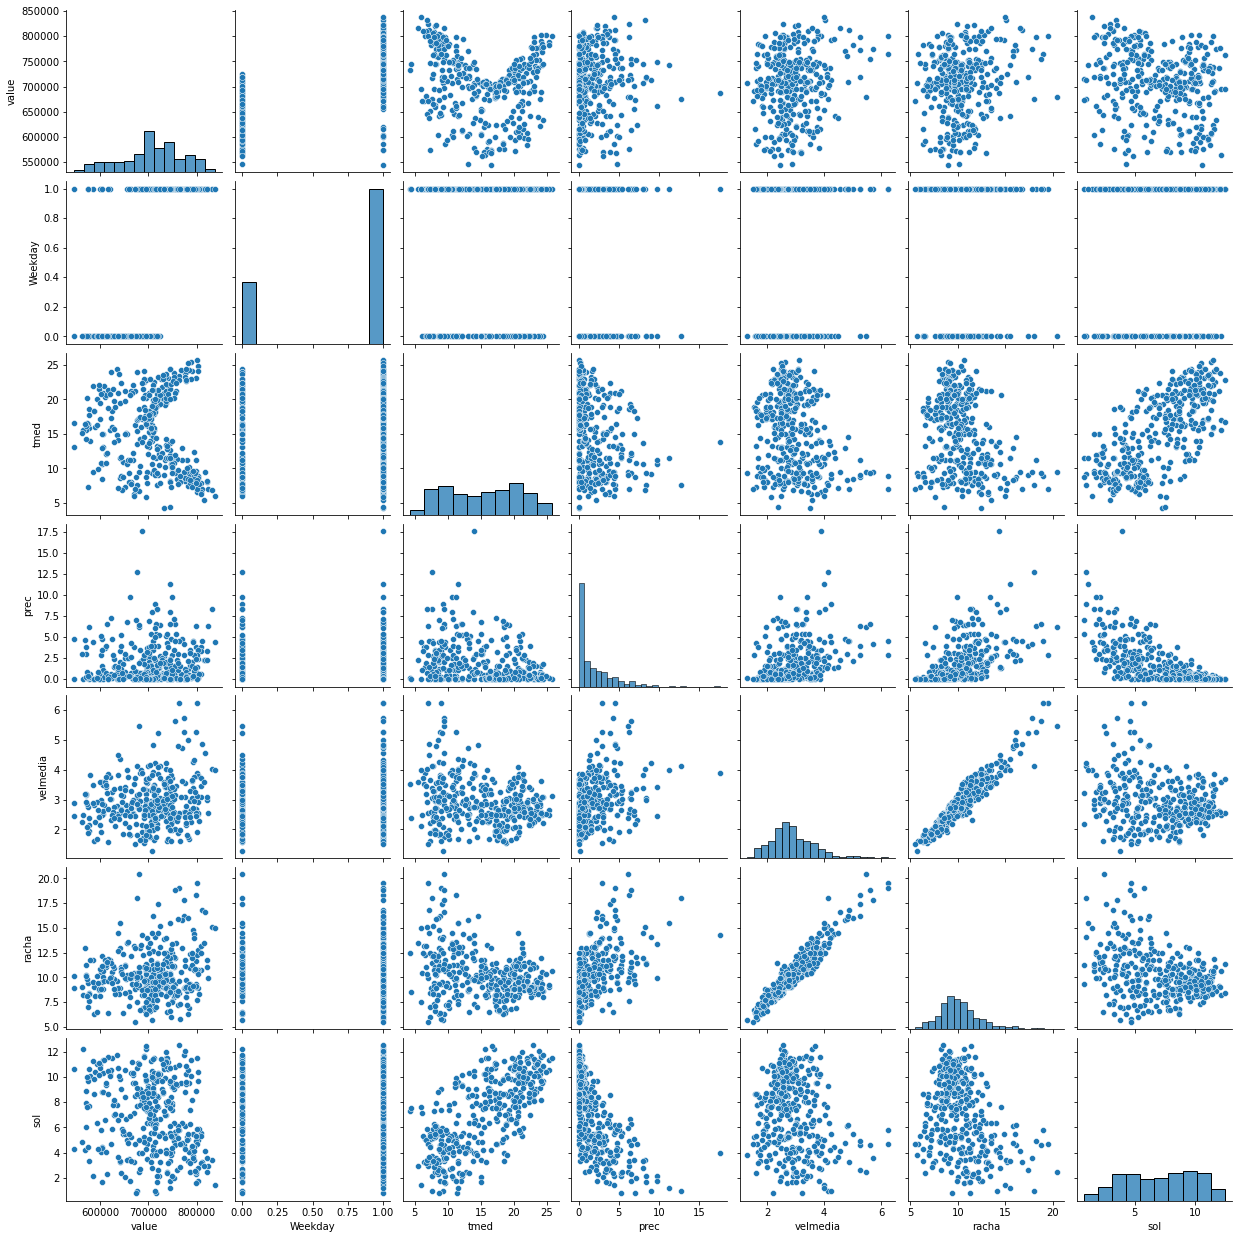

In [56]:
sns.pairplot(demand_weather[['value','Weekday','tmed', 'prec', 'velmedia', 'racha', 'sol']])

It seems that temperature is highly related and that demand is lower when temperature is arond 18 degrees. Let's see in a simple mean how depends demand based on if it is a weekly day or not:

In [57]:
demand_weather.groupby('Weekday')['value'].mean()

Weekday
0    636461.918577
1    733823.044161
Name: value, dtype: float64

<AxesSubplot:xlabel='value', ylabel='Count'>

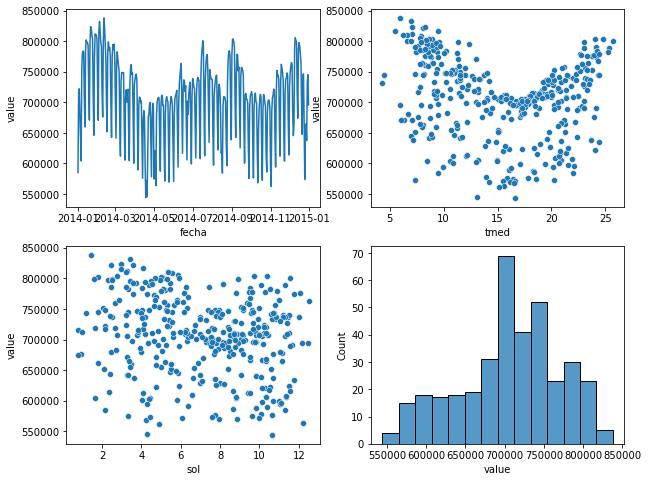

In [64]:
fig, axes = plt.subplots(2,2, figsize = (10,8))

sns.lineplot(ax = axes[0,0], data = demand_weather, x = 'fecha', y = 'value')
sns.scatterplot(ax = axes[0,1], data = demand_weather, x = 'tmed', y = 'value' )
sns.scatterplot(ax = axes[1,0], data = demand_weather, x = 'sol', y = 'value' )
sns.histplot(ax = axes[1,1], data = demand_weather['value'] )

As a first approach, we could consider that energetic demand is higher in a weekday.

# Modelling

In [65]:
from sklearn.linear_model import LinearRegression 
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler

In [70]:
#Let's see if makes sense to create a linear regression model for energetic demand:

X_demand = demand_weather[['Weekday','tmed', 'prec', 'velmedia', 'racha', 'sol']].to_numpy()
y_demand = demand_weather['value'].to_numpy()

In [71]:
#Let's scale the date firstly:

scaler = StandardScaler()
X_demand_scaled = scaler.fit_transform(X_demand)

In [75]:
def lr_model (X,y):

    #Estimator would be LR from sklearn

    reg = LinearRegression()

    # Get the number of the features we are including to reshape accordingly afterwards
    shape = X.shape[1]

    #Reshape in order to have data adjusted

    X = X.reshape(-1,shape)
    y = y.reshape(-1,1)

    print(X.shape)
    print(y.shape)
    
    #Fit in order to train the data
    reg.fit(X,y)

    #We split now the data into train and test
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.15)

    #Metrics of the model we want to know

    predictions = reg.predict(X).round(2)
    MAE = np.round(mean_absolute_error(y_test, reg.predict(X_test)),2)
    r2 = np.round(r2_score(y_test, reg.predict(X_test)),3)
    MSE = np.round(mean_squared_error(y_test,reg.predict(X_test), squared = True),2)
    RMSE = np.round(mean_squared_error(y_test,reg.predict(X_test), squared = False),2)
    cv = cross_val_score(reg, X, y, cv = 5)
    cv_mean = np.round(cv.mean(), 3)
    cv_std = np.round(cv.std(), 3)


    #Outputs
    
    print(f'Model intercept is {reg.intercept_.round(2)}')
    print(f'Model coefficient is {reg.coef_.round(2)}')
    print(f'Model MAE is {MAE}')
    print(f'Model MSE is {MSE}')
    print(f'Model r2 is {r2}')
    print(f'Model RMSE is {RMSE}')
    print(f'CV mean is {cv_mean} and std is {cv_std}')

    return predictions

In [85]:
lr_model(X_demand_scaled, y_demand)

(365, 6)
(365, 1)
Model intercept is [706081.79]
Model coefficient is [[ 44140.93   1966.3  -15185.94 -11659.92  26521.51 -17977.12]]
Model MAE is 33077.28
Model MSE is 1991669436.98
Model r2 is 0.49
Model RMSE is 44628.12
CV mean is 0.214 and std is 0.279


array([[752467.74],
       [754153.68],
       [746317.55],
       [706780.65],
       [677111.31],
       [751293.  ],
       [733120.94],
       [735378.36],
       [741805.87],
       [738251.32],
       [638250.02],
       [643857.1 ],
       [755121.76],
       [769384.89],
       [759245.19],
       [770089.56],
       [747466.92],
       [631821.54],
       [665437.  ],
       [751429.96],
       [727935.13],
       [756285.65],
       [750122.28],
       [747584.26],
       [665025.1 ],
       [664073.94],
       [768855.08],
       [778054.06],
       [765072.6 ],
       [742212.1 ],
       [752117.7 ],
       [686811.02],
       [644345.87],
       [776823.6 ],
       [746601.73],
       [791067.81],
       [769040.21],
       [753939.86],
       [690116.09],
       [667198.25],
       [790184.39],
       [783199.13],
       [762885.9 ],
       [775789.3 ],
       [760807.52],
       [662173.11],
       [638023.32],
       [736302.46],
       [758030.1 ],
       [733118.07],


## KNN Regressor

In [93]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor

In [92]:
def knn_model (X,y):

    #Estimator would be KNN from sklearn

    reg = KNeighborsRegressor()

    # Get the number of the features we are including to reshape accordingly afterwards
    shape = X.shape[1]

    #Reshape in order to have data adjusted

    X = X.reshape(-1,shape)

    print(X.shape)
    print(y.shape)
    
    #Fit in order to train the data
    reg.fit(X,y)

    #We split now the data into train and test
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.15)

    #Metrics of the model we want to know

    predictions = reg.predict(X).round(2)
    MAE = np.round(mean_absolute_error(y_test, reg.predict(X_test)),2)
    r2 = np.round(r2_score(y_test, reg.predict(X_test)),3)
    MSE = np.round(mean_squared_error(y_test,reg.predict(X_test), squared = True),2)
    RMSE = np.round(mean_squared_error(y_test,reg.predict(X_test), squared = False),2)
    cv = cross_val_score(reg, X, y, cv = 5)
    cv_mean = np.round(cv.mean(), 3)
    cv_std = np.round(cv.std(), 3)


    #Outputs
    
 
    print(f'Model MAE is {MAE}')
    print(f'Model MSE is {MSE}')
    print(f'Model r2 is {r2}')
    print(f'Model RMSE is {RMSE}')
    print(f'CV mean is {cv_mean} and std is {cv_std}')

    return predictions

In [91]:
knn_model(X_demand_scaled, y_demand)

(365, 6)
(365,)
Model MAE is 22279.12
Model MSE is 981152110.97
Model r2 is 0.797
Model RMSE is 31323.35
CV mean is 0.411 and std is 0.207


array([729897.64, 700928.04, 735814.25, 745046.63, 659775.41, 716266.79,
       766260.76, 758724.64, 736855.66, 736855.66, 658659.85, 623902.19,
       801279.44, 735191.91, 786131.66, 806098.62, 747330.64, 677128.24,
       654241.16, 784738.85, 731905.43, 801279.44, 772081.92, 777662.78,
       660267.37, 653095.88, 789112.9 , 787398.7 , 792191.89, 778797.87,
       801279.44, 668063.17, 668917.38, 794044.25, 756708.78, 785754.08,
       781729.54, 777522.68, 680382.57, 742498.27, 773356.96, 813944.68,
       801165.38, 766761.17, 753903.8 , 647256.87, 649829.04, 785777.64,
       785378.54, 755312.3 , 769241.66, 784324.42, 666145.37, 635056.75,
       783379.6 , 760588.6 , 772552.2 , 743910.32, 772904.61, 687625.9 ,
       668063.17, 778279.62, 789112.9 , 754346.72, 729373.89, 727278.14,
       620952.1 , 608628.18, 722878.48, 735997.45, 740780.01, 750275.43,
       743159.4 , 642241.92, 620952.1 , 687926.32, 714136.12, 714136.12,
       721063.92, 732500.71, 669281.15, 614941.95, 

In [94]:
def rforest_model (X,y):

    #Estimator would be RandomForest from sklearn

    reg = RandomForestRegressor()

    # Get the number of the features we are including to reshape accordingly afterwards
    shape = X.shape[1]

    #Reshape in order to have data adjusted

    X = X.reshape(-1,shape)

    print(X.shape)
    print(y.shape)
    
    #Fit in order to train the data
    reg.fit(X,y)

    #We split now the data into train and test
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.15)

    #Metrics of the model we want to know

    predictions = reg.predict(X).round(2)
    MAE = np.round(mean_absolute_error(y_test, reg.predict(X_test)),2)
    r2 = np.round(r2_score(y_test, reg.predict(X_test)),3)
    MSE = np.round(mean_squared_error(y_test,reg.predict(X_test), squared = True),2)
    RMSE = np.round(mean_squared_error(y_test,reg.predict(X_test), squared = False),2)
    cv = cross_val_score(reg, X, y, cv = 5)
    cv_mean = np.round(cv.mean(), 3)
    cv_std = np.round(cv.std(), 3)


    #Outputs
    
 
    print(f'Model MAE is {MAE}')
    print(f'Model MSE is {MSE}')
    print(f'Model r2 is {r2}')
    print(f'Model RMSE is {RMSE}')
    print(f'CV mean is {cv_mean} and std is {cv_std}')

    return predictions

In [95]:
rforest_model(X_demand_scaled, y_demand)

(365, 6)
(365,)
Model MAE is 10574.89
Model MSE is 178200043.75
Model r2 is 0.961
Model RMSE is 13349.16
CV mean is 0.375 and std is 0.227


array([658167.21, 726828.04, 723420.89, 693139.69, 652306.5 , 639694.73,
       756528.45, 767191.33, 763598.33, 762157.94, 695228.92, 669699.92,
       789952.87, 803324.45, 766492.29, 798625.34, 792964.89, 707605.19,
       673946.31, 794708.28, 803640.5 , 807847.15, 794899.72, 792369.91,
       687537.25, 642132.17, 776707.35, 810695.31, 813018.34, 801817.06,
       797438.83, 698582.03, 667478.48, 814529.81, 819554.7 , 782555.84,
       778061.64, 785077.95, 709517.57, 689435.84, 798895.52, 827084.26,
       808452.72, 769805.41, 751594.36, 684253.55, 656159.44, 778167.8 ,
       796382.57, 772686.29, 779038.5 , 772170.96, 677981.39, 643803.93,
       781313.63, 787479.64, 780214.19, 795314.58, 764506.42, 707664.58,
       651514.78, 768609.99, 781149.  , 761824.93, 755669.27, 750351.73,
       644717.39, 617533.69, 740151.5 , 748013.35, 744037.75, 750456.01,
       750842.09, 655081.17, 605177.52, 691646.34, 712095.54, 703047.95,
       711072.16, 722939.28, 655479.59, 625403.  , 

It seems that knn regressor is working better, and the best one would be randomforest regressor